pygame 2.6.1 (SDL 2.28.4, Python 3.13.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


TclError: image "⏮" doesn't exist

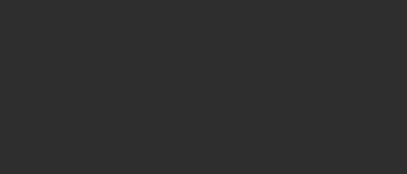

In [1]:
import os
import pygame
import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
from mutagen.mp3 import MP3
import time
import threading

class AdvancedMusicPlayer:
    def __init__(self, root):
        self.root = root
        self.root.title("Advanced Music Player")
        self.root.geometry("900x600")
        self.root.configure(bg='#2d2d2d')
        
        # Initialize pygame mixer
        pygame.mixer.init()
        
        # Player variables
        self.playlist = []
        self.current_song_index = 0
        self.paused = False
        self.playing = False
        self.volume = 0.7
        self.spectrum_active = False
        
        # Create GUI
        self.create_gui()
        
        # Start spectrum updater thread
        self.spectrum_thread = threading.Thread(target=self.update_spectrum, daemon=True)
        self.spectrum_thread.start()
        
        # Bind keyboard shortcuts
        self.root.bind('<space>', lambda event: self.toggle_play_pause())
        self.root.bind('<Left>', lambda event: self.prev_song())
        self.root.bind('<Right>', lambda event: self.next_song())
        self.root.bind('<Up>', lambda event: self.volume_up())
        self.root.bind('<Down>', lambda event: self.volume_down())
    
    def create_gui(self):
        # Main frames
        control_frame = tk.Frame(self.root, bg='#2d2d2d')
        control_frame.pack(side=tk.BOTTOM, fill=tk.X, padx=10, pady=10)
        
        playlist_frame = tk.Frame(self.root, bg='#2d2d2d')
        playlist_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)
        
        visual_frame = tk.Frame(self.root, bg='#2d2d2d')
        visual_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Playlist controls
        self.playlist_box = tk.Listbox(playlist_frame, bg='#3d3d3d', fg='white', 
                                     selectbackground='#1db954', selectforeground='white',
                                     font=('Helvetica', 10), width=30, height=20)
        self.playlist_box.pack(fill=tk.BOTH, expand=True)
        self.playlist_box.bind('<Double-1>', lambda event: self.play_selected())
        
        add_button = tk.Button(playlist_frame, text="Add Songs", command=self.add_songs, 
                             bg='#1db954', fg='white', relief=tk.FLAT)
        add_button.pack(fill=tk.X, pady=5)
        
        remove_button = tk.Button(playlist_frame, text="Remove Selected", command=self.remove_song,
                                bg='#ff4d4d', fg='white', relief=tk.FLAT)
        remove_button.pack(fill=tk.X, pady=5)
        
        # Now playing info
        self.now_playing_label = tk.Label(control_frame, text="Now Playing: ", bg='#2d2d2d', 
                                        fg='white', font=('Helvetica', 10, 'bold'))
        self.now_playing_label.pack(anchor=tk.W)
        
        # Spectrum visualization
        self.fig, self.ax = plt.subplots(figsize=(5, 2), facecolor='#2d2d2d')
        self.ax.set_facecolor('#2d2d2d')
        self.line, = self.ax.plot([], [], color='#1db954')
        self.ax.set_xlim(0, 1000)
        self.ax.set_ylim(0, 1)
        self.ax.axis('off')
        
        self.canvas = FigureCanvasTkAgg(self.fig, master=visual_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Progress bar
        self.progress_bar = ttk.Progressbar(control_frame, orient=tk.HORIZONTAL, length=400, mode='determinate')
        self.progress_bar.pack(fill=tk.X, pady=5)
        
        # Time labels
        time_frame = tk.Frame(control_frame, bg='#2d2d2d')
        time_frame.pack(fill=tk.X)
        
        self.current_time = tk.Label(time_frame, text="00:00", bg='#2d2d2d', fg='white')
        self.current_time.pack(side=tk.LEFT)
        
        self.total_time = tk.Label(time_frame, text="00:00", bg='#2d2d2d', fg='white')
        self.total_time.pack(side=tk.RIGHT)
        
        # Control buttons
        button_frame = tk.Frame(control_frame, bg='#2d2d2d')
        button_frame.pack(pady=10)
        
        # Load icons
        try:
            prev_img = Image.open("prev.png").resize((30, 30))
            self.prev_icon = ImageTk.PhotoImage(prev_img)
            play_img = Image.open("play.png").resize((30, 30))
            self.play_icon = ImageTk.PhotoImage(play_img)
            pause_img = Image.open("pause.png").resize((30, 30))
            self.pause_icon = ImageTk.PhotoImage(pause_img)
            next_img = Image.open("next.png").resize((30, 30))
            self.next_icon = ImageTk.PhotoImage(next_img)
            stop_img = Image.open("stop.png").resize((30, 30))
            self.stop_icon = ImageTk.PhotoImage(stop_img)
        except:
            # Fallback if icons not found
            self.prev_icon = "⏮"
            self.play_icon = "▶"
            self.pause_icon = "⏸"
            self.next_icon = "⏭"
            self.stop_icon = "⏹"
        
        self.prev_button = tk.Button(button_frame, image=self.prev_icon, command=self.prev_song, 
                                   bg='#2d2d2d', relief=tk.FLAT, borderwidth=0)
        self.prev_button.pack(side=tk.LEFT, padx=10)
        
        self.play_button = tk.Button(button_frame, image=self.play_icon, command=self.toggle_play_pause, 
                                   bg='#2d2d2d', relief=tk.FLAT, borderwidth=0)
        self.play_button.pack(side=tk.LEFT, padx=10)
        
        self.stop_button = tk.Button(button_frame, image=self.stop_icon, command=self.stop, 
                                   bg='#2d2d2d', relief=tk.FLAT, borderwidth=0)
        self.stop_button.pack(side=tk.LEFT, padx=10)
        
        self.next_button = tk.Button(button_frame, image=self.next_icon, command=self.next_song, 
                                   bg='#2d2d2d', relief=tk.FLAT, borderwidth=0)
        self.next_button.pack(side=tk.LEFT, padx=10)
        
        # Volume control
        volume_frame = tk.Frame(control_frame, bg='#2d2d2d')
        volume_frame.pack(pady=5)
        
        self.volume_slider = tk.Scale(volume_frame, from_=0, to=100, orient=tk.HORIZONTAL, 
                                    command=self.set_volume, bg='#2d2d2d', fg='white',
                                    highlightbackground='#2d2d2d', troughcolor='#3d3d3d',
                                    activebackground='#1db954')
        self.volume_slider.set(self.volume * 100)
        self.volume_slider.pack()
        
        # Spectrum toggle
        self.spectrum_button = tk.Button(control_frame, text="Toggle Spectrum", 
                                       command=self.toggle_spectrum, bg='#3d3d3d', fg='white')
        self.spectrum_button.pack(pady=5)
        
        # Start progress updater
        self.update_progress()
    
    def add_songs(self):
        files = filedialog.askopenfilenames(filetypes=[("Audio Files", "*.mp3 *.wav *.ogg")])
        for file in files:
            self.playlist.append(file)
            self.playlist_box.insert(tk.END, os.path.basename(file))
    
    def remove_song(self):
        selected = self.playlist_box.curselection()
        if selected:
            index = selected[0]
            self.playlist_box.delete(index)
            self.playlist.pop(index)
            if index == self.current_song_index:
                self.stop()
    
    def play_selected(self):
        selected = self.playlist_box.curselection()
        if selected:
            self.current_song_index = selected[0]
            self.play_song()
    
    def play_song(self):
        if not self.playlist:
            return
            
        song = self.playlist[self.current_song_index]
        pygame.mixer.music.load(song)
        pygame.mixer.music.play()
        self.playing = True
        self.paused = False
        self.play_button.config(image=self.pause_icon)
        
        # Update now playing info
        song_name = os.path.basename(song)
        self.now_playing_label.config(text=f"Now Playing: {song_name}")
        
        # Get song duration
        try:
            audio = MP3(song)
            self.song_length = audio.info.length
            mins, secs = divmod(int(self.song_length), 60)
            self.total_time.config(text=f"{mins:02d}:{secs:02d}")
        except:
            self.song_length = 0
            self.total_time.config(text="00:00")
    
    def toggle_play_pause(self):
        if not self.playlist:
            return
            
        if not self.playing:
            if self.paused:
                pygame.mixer.music.unpause()
                self.paused = False
                self.playing = True
                self.play_button.config(image=self.pause_icon)
            else:
                self.play_song()
        else:
            pygame.mixer.music.pause()
            self.paused = True
            self.playing = False
            self.play_button.config(image=self.play_icon)
    
    def stop(self):
        pygame.mixer.music.stop()
        self.playing = False
        self.paused = False
        self.play_button.config(image=self.play_icon)
        self.progress_bar['value'] = 0
        self.current_time.config(text="00:00")
    
    def next_song(self):
        if not self.playlist:
            return
            
        self.stop()
        self.current_song_index = (self.current_song_index + 1) % len(self.playlist)
        self.play_song()
    
    def prev_song(self):
        if not self.playlist:
            return
            
        self.stop()
        self.current_song_index = (self.current_song_index - 1) % len(self.playlist)
        self.play_song()
    
    def set_volume(self, val):
        self.volume = float(val) / 100
        pygame.mixer.music.set_volume(self.volume)
    
    def volume_up(self):
        new_vol = min(self.volume + 0.1, 1.0)
        self.volume_slider.set(new_vol * 100)
        self.set_volume(new_vol * 100)
    
    def volume_down(self):
        new_vol = max(self.volume - 0.1, 0.0)
        self.volume_slider.set(new_vol * 100)
        self.set_volume(new_vol * 100)
    
    def update_progress(self):
        if self.playing and not self.paused:
            current_pos = pygame.mixer.music.get_pos() / 1000  # Convert to seconds
            if self.song_length > 0:
                progress = (current_pos / self.song_length) * 100
                self.progress_bar['value'] = progress
                
                mins, secs = divmod(int(current_pos), 60)
                self.current_time.config(text=f"{mins:02d}:{secs:02d}")
        
        self.root.after(1000, self.update_progress)
    
    def toggle_spectrum(self):
        self.spectrum_active = not self.spectrum_active
        if self.spectrum_active:
            self.spectrum_button.config(bg='#1db954')
        else:
            self.spectrum_button.config(bg='#3d3d3d')
            self.line.set_data([], [])
            self.canvas.draw()
    
    def update_spectrum(self):
        while True:
            if self.spectrum_active and self.playing:
                # Simulate spectrum data (in a real app, you'd use FFT on the audio stream)
                x = np.linspace(0, 1000, 100)
                y = np.random.rand(100) * 0.5 + 0.5  # Random data for demo
                
                self.line.set_data(x, y)
                self.ax.set_ylim(0, max(y) + 0.1 if max(y) > 0 else 1)
                self.canvas.draw()
            
            time.sleep(0.1)
    
    def run(self):
        self.root.mainloop()

if __name__ == "__main__":
    root = tk.Tk()
    player = AdvancedMusicPlayer(root)
    player.run()